In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import time
from statistics import median
from rsi import apply as rsi

import pyfinancialdata
import trade_functions

from envs import SimpleTradingEnvironment
from agent import DQNAgent
from utils import get_scaler

# Auto reload
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
price_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='GBP_USD',
    years=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
    time_group='12h',
    price_calculation='close',
    drop_non_price_columns=True,
)

In [3]:
# Add column for RSI to use as a feature for learning
price_data['rsi'] = rsi(price_data['price'])
environment_columns = ['rsi', 'price']

# Drop NA columns and reset index
price_data.dropna(inplace=True)

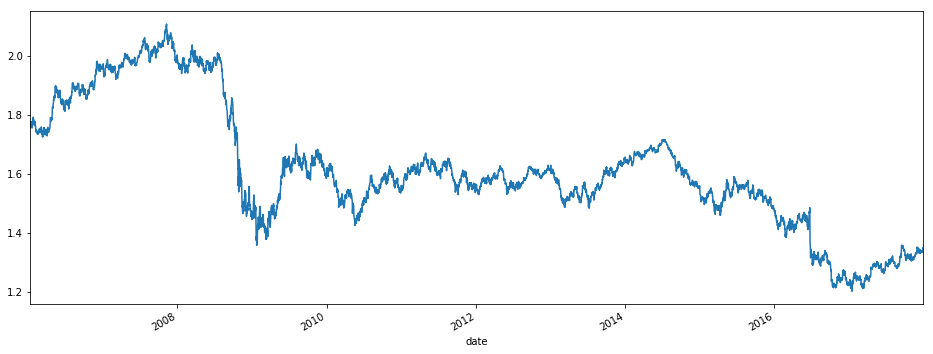

In [4]:
price_data['price'].plot(figsize=(16,6))

In [5]:
train_size = round(len(price_data)/3*2)
train_data = price_data[:train_size].copy()
train_data.reset_index(inplace=True)
test_data = price_data[train_size:].copy()
test_data.reset_index(inplace=True)
print('train size {0}, test size {1}'.format(len(train_data), len(test_data)))

train size 4662, test size 2331


In [6]:
episode=1000
batch_size=10

In [7]:
train_data.head(5)

,date,price,rsi
0,2006-01-10 00:00:00,1.76875,79.629768
1,2006-01-10 12:00:00,1.76420,72.043558
2,2006-01-11 00:00:00,1.75745,62.568899
3,2006-01-11 12:00:00,1.76660,68.571885
4,2006-01-12 00:00:00,1.76835,69.571862


In [8]:
env = SimpleTradingEnvironment(
    price_data=train_data,
    environment_columns=environment_columns,
    debug=False
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
agent = DQNAgent(state_size, action_size)
train_results = pd.DataFrame()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 1,315
Trainable params: 1,315
Non-trainable params: 0
_________________________________________________________________
None


## Train

In [9]:
for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(".", end='')
            if (e + 1) % 20 == 0:
                print("")
                print("episode: {0}/{1}".format(e + 1, episode))
                print("median profit: {0} pips, median trade count: {1}".format(
                    round(median(train_results['account_balance'].tolist()) / 0.0001),
                    round(median(train_results['trade_count'].tolist()))
                    )
                )
            train_results = train_results.append(env._stats(), ignore_index=True)
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
    if (e + 1) % 50 == 0:
        agent.save('{}-dqn.h5'.format(time.strftime('%Y%m%d%H%M')))



....................
episode: 20/1000
median profit: -515 pips, median trade count: 775
....................
episode: 40/1000
median profit: 1579 pips, median trade count: 693
....................
episode: 60/1000
median profit: 2666 pips, median trade count: 701
....................
episode: 80/1000
median profit: 2777 pips, median trade count: 701
....................
episode: 100/1000
median profit: 2371 pips, median trade count: 701
....................
episode: 120/1000
median profit: 1864 pips, median trade count: 672
..

/usr/local/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176565). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


..................
episode: 140/1000
median profit: 1776 pips, median trade count: 667
..

/usr/local/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113565). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


..................
episode: 160/1000
median profit: 1776 pips, median trade count: 672
....................
episode: 180/1000
median profit: 1664 pips, median trade count: 661
....................
episode: 200/1000
median profit: 1469 pips, median trade count: 667
....................
episode: 220/1000
median profit: 1469 pips, median trade count: 681
....................
episode: 240/1000
median profit: 1161 pips, median trade count: 674
....................
episode: 260/1000
median profit: 1160 pips, median trade count: 672
....................
episode: 280/1000
median profit: 1237 pips, median trade count: 672
....................
episode: 300/1000
median profit: 1237 pips, median trade count: 700
....................
episode: 320/1000
median profit: 1004 pips, median trade count: 689
....................
episode: 340/1000
median profit: 1160 pips, median trade count: 699
....................
episode: 360/1000
median profit: 961 pips, median trade count: 693
....................
epi

/usr/local/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


..
episode: 600/1000
median profit: 577 pips, median trade count: 620
....................
episode: 620/1000
median profit: 577 pips, median trade count: 611
....................
episode: 640/1000
median profit: 636 pips, median trade count: 601
....................
episode: 660/1000
median profit: 625 pips, median trade count: 605
....................
episode: 680/1000
median profit: 652 pips, median trade count: 601
....................
episode: 700/1000
median profit: 652 pips, median trade count: 599
....................
episode: 720/1000
median profit: 691 pips, median trade count: 590
....................
episode: 740/1000
median profit: 710 pips, median trade count: 591
....................
episode: 760/1000
median profit: 710 pips, median trade count: 591
....................
episode: 780/1000
median profit: 739 pips, median trade count: 588
....................
episode: 800/1000
median profit: 739 pips, median trade count: 585
....................
episode: 820/1000
median prof

/usr/local/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102709). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


...

/usr/local/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125143). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


..
episode: 960/1000
median profit: 829 pips, median trade count: 522
....................
episode: 980/1000
median profit: 811 pips, median trade count: 507
....................
episode: 1000/1000
median profit: 812 pips, median trade count: 501


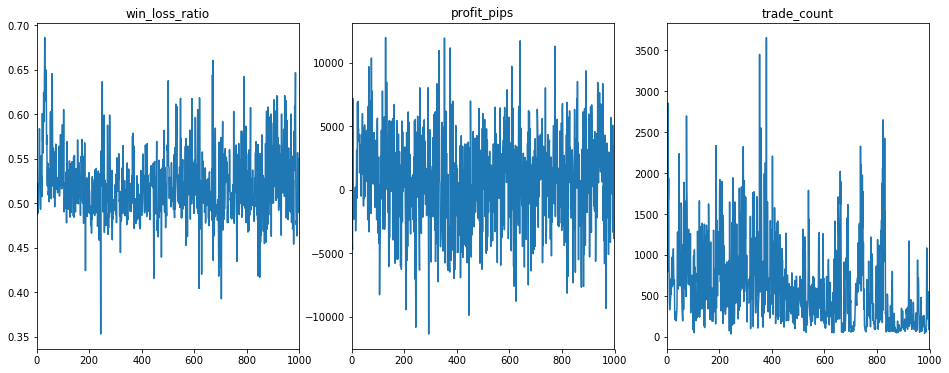

In [10]:
train_results['profit_pips'] = train_results['account_balance'] / 0.0001
columns_to_plot = ['win_loss_ratio', 'profit_pips', 'trade_count']
fig, axes = plt.subplots(nrows=1,ncols=len(columns_to_plot), figsize=(16,6))
for i in range(len(columns_to_plot)):
    axes[i].title.set_text(columns_to_plot[i])
    train_results[columns_to_plot[i]].plot(ax=axes[i], subplots=True)
plt.show()

## Test

In [11]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data,
    environment_columns=environment_columns
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
test_results = pd.DataFrame()

# Uncomment to load trained model from latest saved
# agent = DQNAgent(state_size, action_size)
# latest_model_file = max(glob.glob('*.h5'), key=os.path.getctime)
# print('loading model: {0}'.format(latest_model_file))
# agent.load(latest_model_file)

In [12]:
for e in range(1000):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
        if done:
            test_results = test_results.append(env._stats(), ignore_index=True)
            break

In [13]:
test_results['account_balance_pips'] = test_results['account_balance'] / 0.0001
print('Median profit: {0} pips'.format(test_results['account_balance_pips'].median()))

Median profit: 2513.1500000000183 pips


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x131ed7510>]],
      dtype=object)

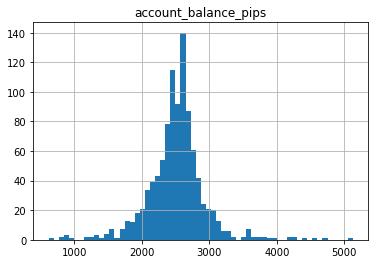

In [14]:
test_results.hist(column='account_balance_pips', bins=60)